In [46]:
# 读取文件
import pandas as pd
data1 = pd.DataFrame()
filename = r'E:\e级机项目\基因聚类算法DCU测试数据-v1\counter1.csv'
chunksize = 1e6    #这个数字设置多少有待考察
for chunk in pd.read_csv(filename, chunksize=chunksize):
    data1 = data1.append(chunk)
pd.set_option("display.max_columns", 50)
# 删去中间几列无意义的属性
data1.drop(labels=data1.columns[2:14], axis=1, inplace=True)


In [47]:
data = data1

In [48]:
data.shape

(4258, 22)

In [49]:
# 统计核函数的数目
data.loc[:, 'KernelName'].value_counts()

void (anonymous namespace)::hip_fill_n<256u, unsigned int*, unsigned long, unsigned int>(unsigned int*, unsigned long, unsigned int)    2987
sameWordCounter(int*, int*, int*)                                                                                                        649
dynamicProgramming(unsigned char*, int, unsigned char*, int, int*, int*, int*, int*)                                                     572
indexTableComputer(unsigned char*, int, int*)                                                                                             50
Name: KernelName, dtype: int64

In [50]:
# 计算每次的运行时间，以及对三次运行时间取平均值
data['elapsed_time'] = data['CompleteNs'] - data['DispatchNs']
# data['elapsed_time_x'] = data['CompleteNs_x'] - data['DispatchNs_x']
# data['elapsed_time_y'] = data['CompleteNs_y'] - data['DispatchNs_y']
# data['elapsed_time_mean'] = (data['elapsed_time'] + data['elapsed_time_x'] + data['elapsed_time_y']) / 3

In [51]:
# 归一化，然后再乘以100
def normalize_data(data):
    data_norm = (data - data.min()) / (data.max() - data.min()) * 100
    return data_norm
# 对数值类型的数据做归一化
# fetch_size和write_size数据分布跨度太大，不适合做归一化
# data['FetchSize_norm'] = normalize_data(data['FetchSize'])
# data['WriteSize_norm'] = normalize_data(data['WriteSize'])
data['elapsed_time_norm'] = normalize_data(data['elapsed_time'])

In [52]:
data_groupby_kernel = data.groupby('KernelName')
data_groupby_kernel_mean = data.groupby('KernelName').mean()
data_groupby_kernel_count = data.groupby('KernelName').count()
data_groupby_kernel_mean['KernelName'] = data_groupby_kernel.size().index
data_groupby_kernel_mean['Count'] = data_groupby_kernel.size()
total_num = sum(data_groupby_kernel.size())
data_groupby_kernel_mean['Frequency'] = data_groupby_kernel_mean['Count'] / total_num * 100

In [53]:
# 获取分组后的id
id_name = data_groupby_kernel.size().index
print(id_name)

Index(['dynamicProgramming(unsigned char*, int, unsigned char*, int, int*, int*, int*, int*)',
       'indexTableComputer(unsigned char*, int, int*)',
       'sameWordCounter(int*, int*, int*)',
       'void (anonymous namespace)::hip_fill_n<256u, unsigned int*, unsigned long, unsigned int>(unsigned int*, unsigned long, unsigned int)'],
      dtype='object', name='KernelName')


In [54]:
data['L2cache hit rate']= data['TCC_HIT_sum'] / (data['TCC_HIT_sum'] + data['TCC_MISS_sum'])

In [55]:
data['L2cache hit rate']

0       0.036800
1       0.198056
2       0.036884
3       0.202206
4       0.036884
          ...   
4253    0.000000
4254    0.195804
4255    0.195804
4256    0.159091
4257    0.999833
Name: L2cache hit rate, Length: 4258, dtype: float64

In [75]:
# 完整版本的脚本
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# plt 中文不乱码
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

def read_file(file_dir):
    data = pd.DataFrame()
    filename = file_dir
    chunksize = 1e6    #这个数字设置多少有待考察
    for chunk in pd.read_csv(filename, chunksize=chunksize):
        data = data.append(chunk)
    # 删去中间几列无意义的属性
    data.drop(labels=data.columns[2:14], axis=1, inplace=True)
    return data

# 归一化
def normalize_data(data):
    data_norm = (data - np.min(data)) / (np.max(data) - np.min(data))
    return data_norm

def draw_radar_map(data):
    for i in range(0, len(data)):
        # 构造数据
        features = ['compute ability', 'momory read', 'memory write', 'L2cache hit rate', 'bandwidth usage']
        values = list()
        for s in features:
#             print(s)
            values.append(data.iloc[i][s])
#         values = [data.iloc[i]['GPUBusy'], data.iloc[i]['VALUUtilization'], \
#              data.iloc[i]['VALUBusy'], data.iloc[i]['L2CacheHit'], data.iloc[i]['MemUnitStalled'], data.iloc[i]['MemUnitBusy'], \
#              # d.iloc[i]['FetchSize'], d.iloc[i]['WriteSize'],\
#              data.iloc[i]['LDSInsts_norm'], data.iloc[i]['Frequency'], data.iloc[i]['elapsed_time_mean_norm'],\
#              data.iloc[i]['LDSBankConflict'], data.iloc[i]['ALUStalledByLDS']]
        
        detailed_features = ['计算能力', '显存读', '显存写', 'L2缓存命中率', '显存带宽利用率']
                
        N = len(detailed_features)
        # 设置雷达图的角度，用于平分切开一个圆面
        angles=np.linspace(0, 2*np.pi, N, endpoint=False)

        # 为了使雷达图一圈封闭起来，需要下面的步骤
        values=np.concatenate((values,[values[0]]))
        angles=np.concatenate((angles,[angles[0]]))
        
        # 使用ggplot的绘图风格
        plt.style.use('ggplot')

        # 绘图
        fig=plt.figure()
        
        # 这里一定要设置为极坐标格式
        ax = fig.add_subplot(111, polar=True)

        # 绘制折线图
        ax.plot(angles, values, 'o--', linewidth=2)
        # 填充颜色
        ax.fill(angles, values, alpha=0.25)
        # 添加每个特征的标签
        ax.set_thetagrids(angles * 180/np.pi, detailed_features)
        # 设置雷达图的范围
        ax.set_ylim(0,100)

        # 标题
        plt.title(data.iloc[i]['KernelName'], pad=25)
        
        # 添加网格线
        ax.grid(True)
        # 显示图形
        plt.show()
        

def draw_bar_pic(data_x, data_y, title, y_label):
    plt.ylabel(y_label)
    x_ticks_list = ['kernel' + str(x) for x in range(1, len(data_x)+1)]
    plt.bar(data_x, data_y, width=0.35)
    plt.xticks(data_x, x_ticks_list)
    plt.title(title)
    text_height_margin = max(data_y)/50
    # 加入具体数值的标签
    for x, y in enumerate(data_y):
        plt.text(x, y + text_height_margin, '%s' % int(round(data_y[x])), verticalalignment="bottom",horizontalalignment="center")
    plt.show()
    
def draw_bar_pic_two_bars(data_x, data_y1, data_y2, label1, label2, title, y_label):
    plt.ylabel(y_label)
    x_ticks_list = ['kernel' + str(x) for x in range(1, len(data_x)+1)]
    bar_width = 0.4
    x_loc = np.arange(len(data_x))#柱状图在横坐标上的位置
    plt.bar(x_loc, data_y1, label=label1, color='steelblue', width=bar_width)
#     plt.bar(data_x, data_y2, bottom=data_y1, label=label2, color='indianred', width=0.8)
    
    plt.bar(x_loc + bar_width, height=data_y2, label=label2, color='indianred', width=bar_width)
    
    text_height_margin = max(data_y1)/50
    # 加入具体数值的标签
    for x, y in enumerate(data_y1):
        plt.text(x, y + text_height_margin, '%s' % int(round(data_y1[x])), verticalalignment="bottom",horizontalalignment="center")
        
    text_height_margin = max(data_y2)/50
    for x, y in enumerate(data_y2):
        plt.text(x + bar_width, y + text_height_margin, '%s' % int(round(data_y2[x])), verticalalignment="bottom",horizontalalignment="center")
    
    plt.xticks(x_loc + bar_width / 2, x_ticks_list)#显示x坐标轴的标签,即tick_label,调整位置，使其落在两个直方图中间位置
#     plt.xticks(data_x, x_ticks_list)
    plt.legend()
    plt.title(title)
    plt.show()

def process_data(data):
    # 计算每次的运行时间
    data['elapsed_time'] = data['CompleteNs'] - data['DispatchNs']
    
    data['compute ability'] = (data['SQ_INSTS_SALU'] + data['SQ_INSTS_VALU']) / (data['GRBM_COUNT'] / 1300000*1000) / 679
#     print(data['compute ability'])
    data['momory read']     = (data['SQ_INSTS_VMEM_RD'] + data['SQ_INSTS_SMEM'] - data['TA_FLAT_READ_WAVEFRONTS_sum']) / 100 / 41943 * 100
    print(max(data['momory read']))
    data['memory write']    = (data['SQ_INSTS_VMEM_WR'] - data['TA_FLAT_WRITE_WAVEFRONTS_sum']) / 1000 * 100
    print(max(data['memory write']))
    data['L2cache hit rate']= data['TCC_HIT_sum'] / (data['TCC_HIT_sum'] + data['TCC_MISS_sum']) * 100
    data['bandwidth usage'] = (data['TCC_EA_WRREQ_sum'] + data['TCC_EA_RDREQ_sum']) / (data['GRBM_COUNT'] / 1300000*1000) / 1000 / 5.5 * 100
    print(max(data['bandwidth usage']))
    
    return data

def groupby_and_mean_data(data):
    # 计算每种核函数出现的频率（frequency）
    data_groupby_kernel = data.groupby('KernelName')
    # 根据核函数名字来分组，并求平均值和次数
    data_groupby_kernel_mean = data.groupby('KernelName').mean()
    data_groupby_kernel_sum = data.groupby('KernelName').sum()
    # 每种核函数的名字
    data_groupby_kernel_mean['KernelName'] = data_groupby_kernel.size().index
    # 每种核函数出现的频率
    data_groupby_kernel_mean['Count'] = data_groupby_kernel.size()
    kernel_total_num = sum(data_groupby_kernel.size())
    data_groupby_kernel_mean['Frequency'] = data_groupby_kernel_mean['Count'] / kernel_total_num * 100
    # 每种核函数运行时间占总时间的比例
    sum_of_time = sum(data['elapsed_time'])
    data_groupby_kernel_mean['percentage of total time'] = data_groupby_kernel_sum['elapsed_time'] / sum_of_time * 100
    # 将单位从纳秒转换为微秒
    data_groupby_kernel_mean['elapsed_time'] /= (10 ** 6)
    return data_groupby_kernel_mean

def visualize_data(file_path1):
     # 分别读入三个文件中的指标
#     data1 = read_file(r'E:\e级机项目\部分衍生参数的性能测试结果-v2\gromacs_2_dreived\counterOne0.csv')
#     data2 = read_file(r'E:\e级机项目\部分衍生参数的性能测试结果-v2\gromacs_2_dreived\counterTwo0.csv')
#     data3 = read_file(r'E:\e级机项目\部分衍生参数的性能测试结果-v2\gromacs_2_dreived\counterThree0.csv')

    data = read_file(file_path1)

    print("read file successfully!")

    # 处理数据
    data = process_data(data)
    
    # 对数据分组，并且求均值
    data_groupby_kernel_mean = groupby_and_mean_data(data)
    
    # 绘制雷达图
    draw_radar_map(data_groupby_kernel_mean)
    
    # 绘制柱状图
#     draw_bar_pic(data_groupby_kernel_mean['KernelName'], data_groupby_kernel_mean['WriteSize'], 'WriteSize')
#     draw_bar_pic(data_groupby_kernel_mean['KernelName'], data_groupby_kernel_mean['FetchSize'], 'FetchSize')
#     draw_bar_pic_two_bars(data_groupby_kernel_mean['KernelName'], \
#                           data_groupby_kernel_mean['FetchSize'], \
#                           data_groupby_kernel_mean['WriteSize'], \
#                           '读', '写', "各核函数显存读写统计图", "大小(KB)")
    
    draw_bar_pic_two_bars(data_groupby_kernel_mean['KernelName'], \
                          data_groupby_kernel_mean['Frequency'], \
                          data_groupby_kernel_mean['percentage of total time'], \
                          '调用频率', '占总运行时间百分比', "各核函数调用频率及运行时间占总时间比例统计图", "百分比(%)")
    
    draw_bar_pic(data_groupby_kernel_mean['KernelName'], data_groupby_kernel_mean['elapsed_time'], '各核函数平均运行时间统计图', "时间(ms)")


read file successfully!
0.09765634313234628
12.8
3.7337502792048243


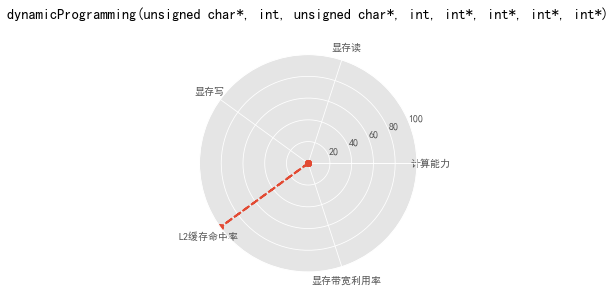

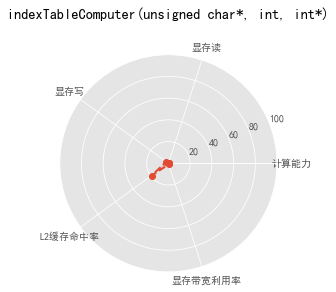

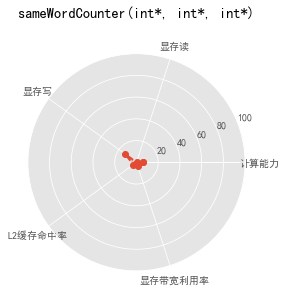

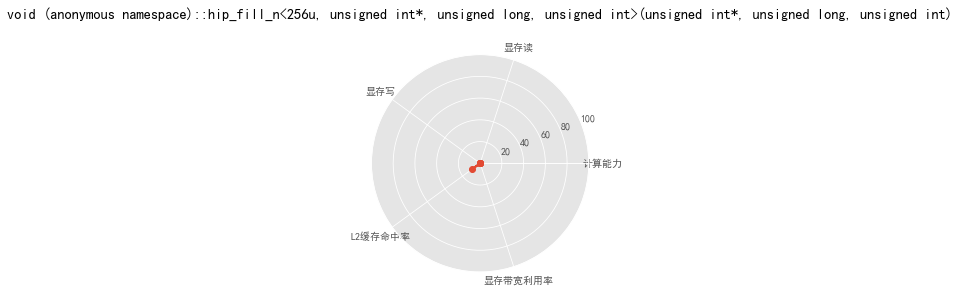

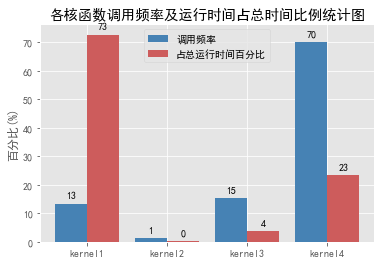

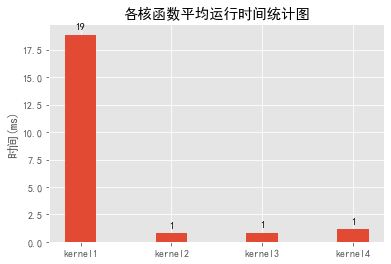

In [77]:
visualize_data(r'E:\e级机项目\基因聚类算法DCU测试数据-v1\counter1.csv')

read file successfully!
3.477505185609041
6.4
3.6672719833081393


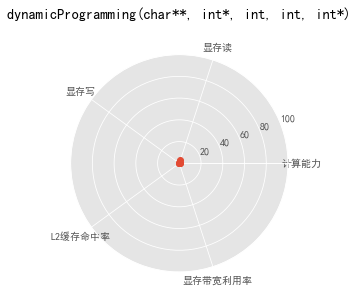

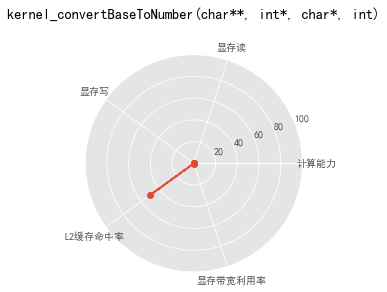

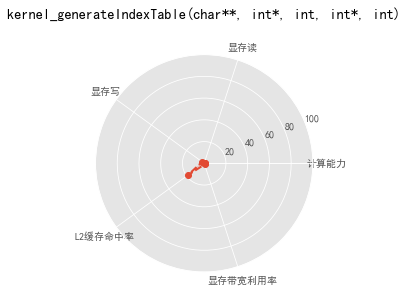

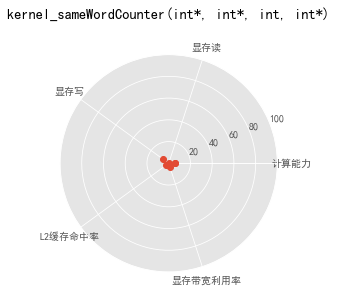

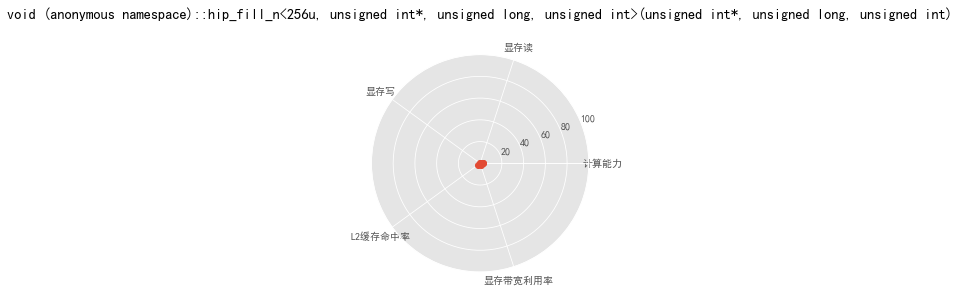

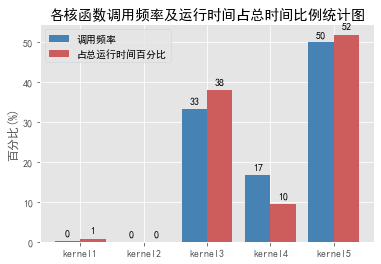

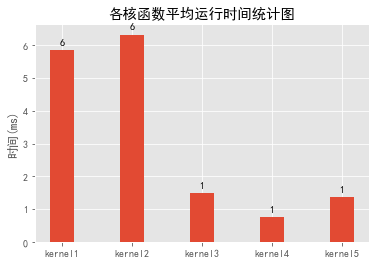

In [78]:
visualize_data(r'E:\e级机项目\基因聚类算法DCU测试数据-v1\counter2.csv')

read file successfully!
0.03433230813246549
0.0
0.010967187755136078


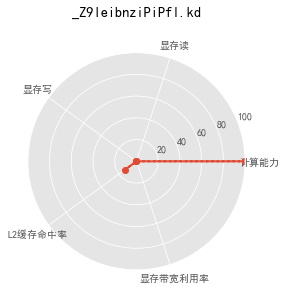

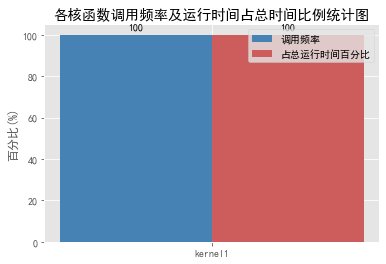

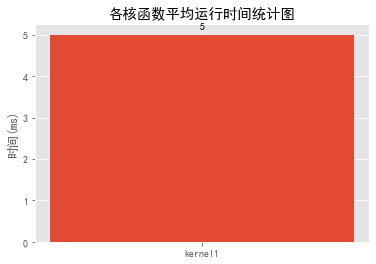

In [79]:
visualize_data(r'E:\e级机项目\基因聚类算法DCU测试数据-v1\test.csv')

read file successfully!
100.00019073504518
0.0
99.32840537868469


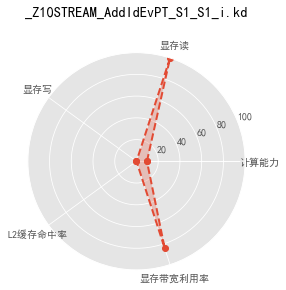

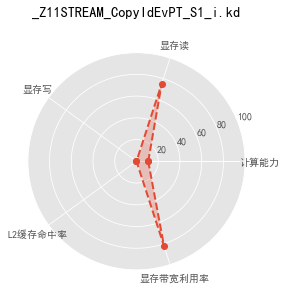

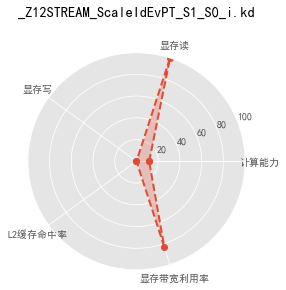

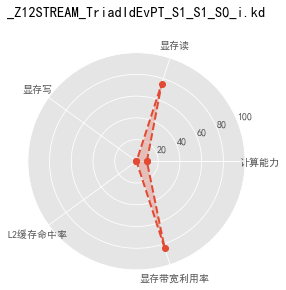

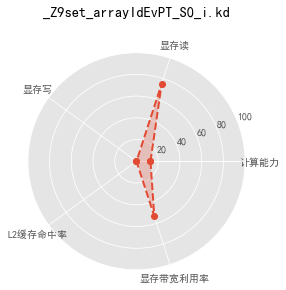

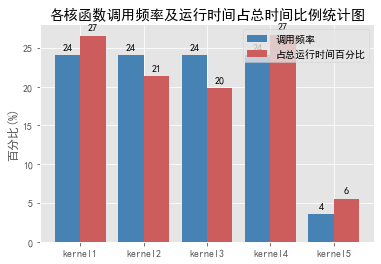

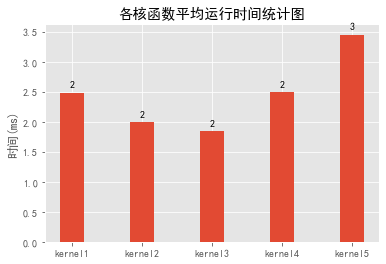

In [80]:
visualize_data(r'E:\e级机项目\基因聚类算法DCU测试数据-v1\stream memory bandwidth.csv')